In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import wfdb
import time
import random
from sklearn.preprocessing import minmax_scale
import sys
import pandas
from torch.utils.tensorboard import SummaryWriter

In [2]:
# load real data (ptbdb)
# with open('ptbdb_data/RECORDS') as fp:  
#     lines = fp.readlines()
with open('staff-iii-database-1.0.0/RECORDS') as fp:  
    lines = fp.readlines()
    
lines = lines[:int(0.8*len(lines))]

In [3]:
lines[:10]

['data/001a\n',
 'data/001b\n',
 'data/001c\n',
 'data/001d\n',
 'data/002a\n',
 'data/002b\n',
 'data/002c\n',
 'data/002d\n',
 'data/002e\n',
 'data/002f\n']

In [10]:
len(lines)

416

In [4]:
df = pandas.read_excel('staff-iii-database-1.0.0/STAFF-III-Database-Annotations.xlsx')
labels = df[u'Unnamed: 28'][8:].as_matrix()

/mnt/project/grp_202/arjung2/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [5]:
labels[85]

u'anterior'

In [9]:
files_unhealthy, files_healthy = [], []

for file_ in lines:
        
    patient_id = int(file_[5:8])
        
    '''
    print(file_[:-1], patient_id, labels[patient_id], labels[patient_id] == "no")
            
    if labels[patient_id] == "no":
        files_healthy.append(file_)
    else:
        files_unhealthy.append(file_)
    '''
        
    file_name = file_[:-1]
    data, _ = wfdb.rdsamp("staff-iii-database-1.0.0/" + str(file_name))
    data = np.array(data) # (300000, 9)

    if np.isnan(np.sum(data)):
        print(file_[:-1], patient_id, labels[patient_id], labels[patient_id] == "no")

data/001c 1 no True
data/005c 5 no True
data/019c 19 no True
data/019d 19 no True
data/021d 21 inferior False
data/022c 22 no True
data/023c 23 no True
data/026d 26 no True
data/041a 41 no True
data/048b 48 no True
data/048c 48 no True
data/051d 51 no True
data/053e 53 no True
data/063c 63 no True
data/079d 79 no True
data/080d 80 no True
data/081c 81 anterior False


In [16]:
np.random.shuffle(files_unhealthy)
np.random.shuffle(files_healthy)

In [17]:
print(files_unhealthy[:10])
print(files_healthy[:10])

['data/027a\n', 'data/016a\n', 'data/020c\n', 'data/017e\n', 'data/008a\n', 'data/065b\n', 'data/085a\n', 'data/011f\n', 'data/035c\n', 'data/002e\n']
['data/032e\n', 'data/083b\n', 'data/070c\n', 'data/031c\n', 'data/072d\n', 'data/079e\n', 'data/033f\n', 'data/031d\n', 'data/030a\n', 'data/023a\n']


In [18]:
data_unhealthy = []
for file in files_unhealthy:
    data_v4, _ = wfdb.rdsamp("staff-iii-database-1.0.0/" + file[:-1])
    # data = [data_v4.flatten()]
    data = (data_v4[:, 7]).flatten()
    data_unhealthy.append(data)
data_healthy = []
for file in files_healthy:
    data_v4, _ = wfdb.rdsamp("staff-iii-database-1.0.0/" + file[:-1])
    # data = [data_v4.flatten()]
    data = (data_v4[:, 7]).flatten()
    data_healthy.append(data)

In [20]:
data_unhealthy = np.asarray(data_unhealthy)
data_healthy = np.asarray(data_healthy)

print(data_unhealthy.shape)
print(data_healthy.shape)

num_unhealthy = (data_unhealthy.shape)[0]
num_healthy = (data_healthy.shape)[0]

print(num_unhealthy, num_healthy)

(141,)
(275,)
141 275


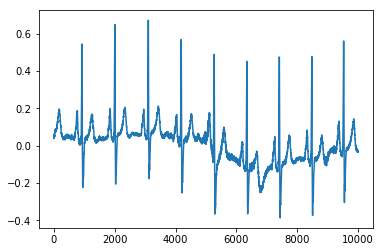

In [24]:
plt.plot(data_healthy[0][130000:140000])

In [25]:
window_size = 10000

def get_batch(batch_size, split='train'):
    
    unhealthy_threshold = int(0.8*num_unhealthy)
    healthy_threshold = int(0.8*num_healthy)
    
    unhealthy_test_threshold = int(0.9*num_unhealthy)
    healthy_test_threshold = int(0.9*num_healthy)
    
    if split == 'train':
        unhealthy_indices = random.sample(np.arange(unhealthy_threshold), k=int(batch_size / 2))
        healthy_indices = random.sample(np.arange(healthy_threshold), k=int(batch_size / 2))
    elif split == 'val': 
        unhealthy_indices = random.sample(unhealthy_threshold + np.arange(unhealthy_test_threshold - unhealthy_threshold), k=int(batch_size / 2))
        healthy_indices = random.sample(healthy_threshold + np.arange(healthy_test_threshold - healthy_threshold), k=int(batch_size / 2))
    elif split == 'test':
        unhealthy_indices = random.sample(unhealthy_test_threshold + np.arange(num_unhealthy - unhealthy_test_threshold), k=int(batch_size / 2))
        healthy_indices = random.sample(healthy_test_threshold + np.arange(num_healthy - healthy_test_threshold), k=int(batch_size / 2))
            
    unhealthy_batch = data_unhealthy[unhealthy_indices]
    healthy_batch = data_healthy[healthy_indices]
    
    batch_x = []
    for sample in unhealthy_batch:
        
        start = random.choice(np.arange(len(sample) - window_size))
        
        # normalize
        normalized_1 = minmax_scale(sample[start:start+window_size])
        normalized = np.array(normalized_1)
        
        batch_x.append(normalized)
        
    for sample in healthy_batch:
        
        start = random.choice(np.arange(len(sample) - window_size))
        
        # normalize
        normalized_1 = minmax_scale(sample[start:start+window_size])
        normalized = np.array(normalized_1)
        
        batch_x.append(normalized)
    
    batch_y = [0 for _ in range(int(batch_size / 2))]
    for _ in range(int(batch_size / 2)):
        batch_y.append(1)
        
    indices = np.arange(len(batch_y))
    np.random.shuffle(indices)
    
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    
    batch_x = batch_x[indices]
    batch_y = batch_y[indices]
    
    batch_x = np.reshape(batch_x, (-1, 1, window_size))
    batch_x = torch.from_numpy(batch_x)
    batch_x = batch_x.float().cuda()
    batch_x = batch_x.float()
    
    batch_y = np.reshape(batch_y, (-1, 1))
    batch_y = torch.from_numpy(batch_y)
    batch_y = batch_y.float().cuda()
    batch_y = batch_y.float()
    
    return batch_x, batch_y

In [27]:
batch_x, batch_y = get_batch(10, split='train')

In [28]:
batch_x.shape

torch.Size([10, 1, 10000])

In [29]:
batch_y

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]], device='cuda:0')

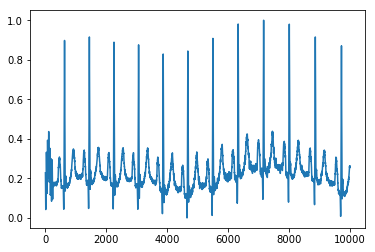

In [35]:
plt.plot(batch_x[7][0].cpu())
plt.show()

In [36]:
# load real data (ptbdb)
with open('ptbdb_data/RECORDS') as fp:  
    lines = fp.readlines()

files_unhealthy, files_healthy = [], []

for file in lines:
    file_path = "ptbdb_data/" + file[:-1] + ".hea"
    
    # read header to determine class
    if 'Myocardial infarction' in open(file_path).read():
        files_unhealthy.append(file)
        
    if 'Healthy control' in open(file_path).read():
        files_healthy.append(file)

# shuffle data (cross-validation)
# np.random.seed(int(seed_num))
np.random.shuffle(files_unhealthy)
np.random.shuffle(files_healthy)
        
data_unhealthy = []
for file in files_unhealthy:
    data_v4, _ = wfdb.rdsamp("ptbdb_data/" + file[:-1], channel_names=[str('i')])
    data = data_v4.flatten()
    data_unhealthy.append(data)
data_healthy = []
for file in files_healthy:
    data_v4, _ = wfdb.rdsamp("ptbdb_data/" + file[:-1], channel_names=[str('i')])
    data = data_v4.flatten()
    data_healthy.append(data)
    


data_unhealthy = np.asarray(data_unhealthy)
data_healthy = np.asarray(data_healthy)

num_unhealthy = (data_unhealthy.shape)[0]
num_healthy = (data_healthy.shape)[0]

In [37]:
batch_x, batch_y = get_batch(10, split='train')

In [38]:
batch_x.shape

torch.Size([10, 1, 10000])

In [39]:
batch_y

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

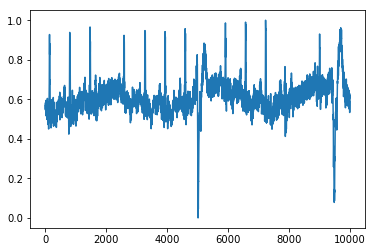

In [43]:
plt.plot(batch_x[2][0].cpu())
plt.show()